# Credit Card Fraud Detection
---

- **Baza danych:**

Source: https://datahub.io/machine-learning/creditcard

Baza zawiera ... rekordów z 30 cechami + pole klasy. Pola V1 ... V28 są pewnymi cechami transakcji, transformowanymi metodą PCA. Baza zawiera 284807 rekordów dla których transakcja była prawidłowo autoryzowana oraz 492 rekordy oznaczonych jako oszustwo. 


- **Cel:**

Na podstawie danych zawartych w bazie wykrycie prób oszustwa.  

In [2]:
import datapackage
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Wczytanie i wstępne przetworzenie danych



- Usunięto powielone dane
- Z danych usunięto cechy `Amount` oraz `Time`
- Dane podzielono na zbiór uczący oraz testowy
- Podzbiory rozdzielono na te zawierające *anomalie* oraz *poprawne transakcje* (ze względu na to iż autoenkoder uczony oraz walidowany jest tylko na zbiorach zawierających *poprawne transakcje*, wszystkie *oszustwa* dodano do zbioru testowego)

*Więcej w sekcji poniżej*

In [3]:
data_url = 'https://datahub.io/machine-learning/creditcard/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        data_pd = pd.read_csv(resource.descriptor['path'])

data = data_pd.to_numpy()

In [4]:
# Remove duplicated data
duplicated = data_pd.duplicated().to_numpy()
data = data[~duplicated]

In [5]:
idx_fraud   = np.where(data[:,-1] == "'1'")
idx_neutral = np.where(data[:,-1] == "'0'")

print("Fraud transaction amount:")
print("AVG: :", np.average(data[idx_fraud,-2]))
print("VAR: :",np.var(data[idx_fraud,-2]))

print("Neutral transaction amount:")
print("AVG: :",np.average(data[idx_neutral,-2]))
print("VAR: :",np.var(data[idx_neutral,-2]))

Fraud transaction amount:
AVG: : 123.87186046511626
VAR: : 67566.63602064028
Neutral transaction amount:
AVG: : 88.41357475466688
VAR: : 62689.43379439356


In [6]:
# Data preprocessing

# 1 - correct transaction, 0 - fraud
labels = np.zeros(data.shape[0], dtype=np.uint8)
labels[np.where(data[:,-1] == "'0'")[0]] = 1

# Remove time and amount 
data = data[:, 1:-2]

In [7]:
# Split data for training and test
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2)

# Normalize data
scn = Normalizer().fit(train_data)
train_data = scn.transform(train_data)
test_data  = scn.transform(test_data)
data = scn.transform(data)

In [8]:
# Split training data for normal and anomalous
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# For training use only normal transaction so anomalous from train can be added to test set
#anomalous_train_data = train_data[~train_labels]
#anomalous_test_data  = test_data[~test_labels]
anomalous_test_data = np.concatenate((test_data[~test_labels], train_data[~train_labels]))

## Model sieci / uczenie

Ze względu na dużą dysproporcje w danych (stosunek *autoryzowanych transakcji* do *transakcji oznaczonych jako oszustwo*) zaproponowano model sieci oparty na działaniu autoenkodera w trybie wykrywania anomalii. 

Gdzie:
- Poprawnej transakcji przypisano wartość `1`
- Próbie oszustwa przypisano wartość `0`

Autoenkoder uczony jest tylko i wyłącznie poprawnymi transakcjami tak by błąd rekonstrukcji, w poprawnych transakcjach był jak najmniejszy.

Poniżej przedstawiono model który dostarczał najlepszych wyników.

*W sekcji końcowej przedstawiono testowane modele*

In [150]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Conv1D(20, 3, activation="relu", input_shape = (28,1)),
        layers.Dropout(0.2),
        layers.Conv1D(10, 3, activation="relu"),
        layers.Dropout(0.3),
        layers.Conv1D(6, 3, activation="relu"),
        layers.Dropout(0.2)
        ])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(10, 5, activation="relu"),
      layers.Dropout(0.3),
      layers.Conv1DTranspose(20, 5, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1D(1, 3, activation="sigmoid"),
      layers.Flatten()
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [141]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Conv1D(20, 3, activation="relu", input_shape = (28,1)),
        layers.Dropout(0.2),
        layers.Conv1D(10, 3, activation="relu"),
        layers.Dropout(0.3),
        layers.Conv1D(6, 3, activation="relu"),
        layers.Dropout(0.2)
        ])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(6, 3, activation="relu"),
      layers.Dropout(0.3),
      layers.Conv1DTranspose(10, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1DTranspose(1, 3, activation="sigmoid"),
      layers.Flatten()
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [151]:
autoencoder.compile(optimizer='adam', loss='mae')

In [152]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=80, 
          batch_size=256,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/80
886/886 [==============================] - 12s 12ms/step - loss: 0.1576 - val_loss: 0.1339
Epoch 2/80
886/886 [==============================] - 10s 11ms/step - loss: 0.1137 - val_loss: 0.0885
Epoch 3/80
886/886 [==============================] - 10s 11ms/step - loss: 0.0954 - val_loss: 0.0847
Epoch 4/80
886/886 [==============================] - 10s 11ms/step - loss: 0.0919 - val_loss: 0.0833
Epoch 5/80
886/886 [==============================] - 10s 11ms/step - loss: 0.0897 - val_loss: 0.0815
Epoch 6/80
886/886 [==============================] - 10s 11ms/step - loss: 0.0883 - val_loss: 0.0809
Epoch 7/80
886/886 [==============================] - 10s 12ms/step - loss: 0.0873 - val_loss: 0.0806
Epoch 8/80
886/886 [==============================] - 10s 11ms/step - loss: 0.0866 - val_loss: 0.0805
Epoch 9/80
886/886 [==============================] - 10s 12ms/step - loss: 0.0861 - val_loss: 0.0804
Epoch 10/80
886/886 [==============================] - 10s 11ms/step - loss: 0.085

### Krzywe uczenia

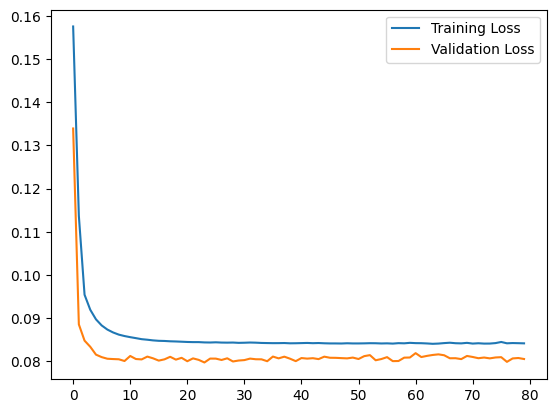

In [153]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Uzyskane wyniki

Poniżej przedstawiono uzyskane wyniki. 

Histogramy funkcji straty (błędu rekonstrukcji) dla *poprawnych* przypadków użycia karty oraz dla prób *oszustwa*. **Im mniejszy obszar wspólny tym lepiej**

Krzywe FAR i FRR pozwalające ręcznie wyznaczyć próg akceptacji błędu rekonstrukcji. **Im mniejszy próg tym system bardziej restrykcyjny**

ROC wykres przedstawiający zależność między FAR a FRR dla różnych progów klasyfikacji. Area Under the Curve (AUC) pole pod krzywą. **Im większa jest AUC, tym lepszy jest klasyfikator**

15/15 [==============================] - 0s 2ms/step


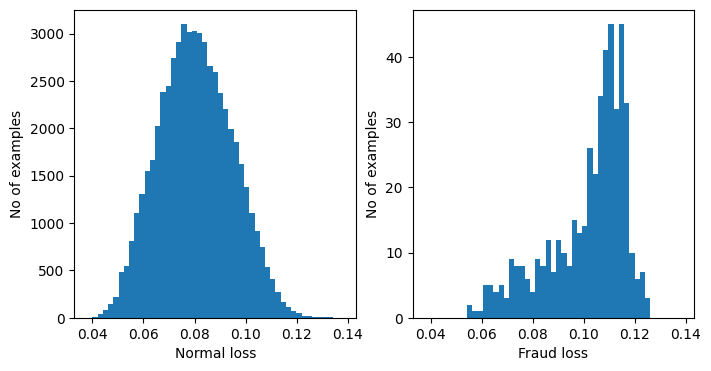

In [154]:
# Reconstructions for training normal data
reconstructions = autoencoder.predict(normal_test_data)
normal_train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

# Reconstructions for test anomalous
reconstructions = autoencoder.predict(anomalous_test_data)
anomalous_test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

bins = np.linspace(
    np.min((np.min(normal_train_loss), np.min(anomalous_test_loss))), 
    np.max((np.max(normal_train_loss), np.max(anomalous_test_loss))),
    50)

fig = plt.figure()
fig.set_size_inches(8,4)

plt.subplot(1,2,1)
plt.hist(normal_train_loss[None,:],   bins=bins, label='normal_train')
plt.xlabel("Normal loss")
plt.ylabel("No of examples")

plt.subplot(1,2,2)
plt.hist(anomalous_test_loss[None,:], bins=bins, label='anomalous_test')
plt.xlabel("Fraud loss")
plt.ylabel("No of examples")
plt.show()

#### Statystyki FAR i FRR

In [155]:
def get_statistics(loss, labels, threshold):
    classified = np.array(loss < threshold, dtype = np.uint8)
    diff_arg = np.where(classified != labels)[0]
    frr = np.count_nonzero(classified[diff_arg] == 0) / np.count_nonzero(labels == 1)
    far = np.count_nonzero(classified[diff_arg] == 1) / np.count_nonzero(labels == 0)
    return far, frr

8867/8867 [==============================] - 26s 3ms/step


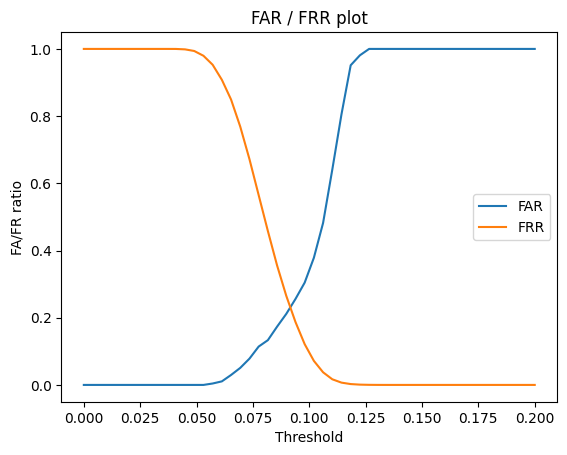

In [156]:
# Reconstruction for all data
reconstructions = autoencoder.predict(data)
loss = tf.keras.losses.mae(reconstructions, data)

# Minimal and maximal value of threshold
threshold_min = np.min(reconstructions) 
threshold_max = np.max(reconstructions)
threshold_max = 0.2

threshold_range = np.linspace(threshold_min, threshold_max, 50)

# Set FAR and FRR
far = np.zeros(threshold_range.shape)
frr = np.zeros(threshold_range.shape)
for i in range(threshold_range.shape[0]):
    far[i], frr[i] = get_statistics(loss, labels, threshold_range[i])

plt.title('FAR / FRR plot')
plt.plot(threshold_range, far, label='FAR')
plt.plot(threshold_range, frr, label='FRR')
plt.ylabel('FA/FR ratio')
plt.xlabel("Threshold")
plt.legend()
plt.show()

###  Krzywa ROC oraz DET

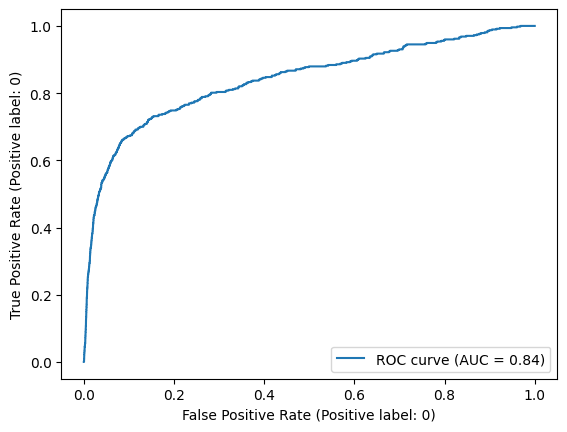

In [157]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

RocCurveDisplay.from_predictions(labels, loss, pos_label=0, name="ROC curve")
plt.show()

In [158]:
# Automatic set threshold 
hreshold = np.mean(normal_train_loss) + np.std(normal_train_loss)
print("Threshold: ", threshold)

Threshold:  0.09956049195450627


In [159]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))


In [160]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.899481901808057
Precision = 0.999470629754529
Recall = 0.8997952483496311


## Wnioski

Najlepsze wyniki uzyskano dla  sieci splotowych. W zależności od zadanego progu można dopasować model do zastosowań. Modyfikacje wartości progowej (wartości błędu rekonstrukcji) wpływa na restrykcyjność systemu. Bez losowego zaburzania części waga, sieć często zatrzymywała się w lokalnym minimum. 

## Inne testowane modele

In [ ]:
# Model 1 : Warstwy gęste
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(18, activation="relu", input_shape = (28,)),
      layers.Dense(10, activation="relu"),
      layers.Dense(4, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(10, activation="relu"),
      layers.Dense(18, activation="relu"),
      layers.Dense(28, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Model 2 : Warstwy gęste
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(22, activation="relu"),
      layers.Dense(18, activation="relu"),
      layers.Dense(14, activation="relu"),
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(18, activation="relu"),
      layers.Dense(22, activation="relu"),
      layers.Dense(28, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Model 3 : Warstwy gęste
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu", input_shape = (28,)),
      layers.Dense(64, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(12, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(28, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Model 4 : Warstwy splotowe
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Conv1D(14, 3, activation="relu", input_shape = (28,1)),
        layers.Dropout(0.2),
        layers.Conv1D(8, 5, activation="relu"),
        layers.Dropout(0.3),
        layers.Conv1D(4, 8, activation="relu"),
        layers.Dropout(0.2)
        ])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(8, 8, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1DTranspose(14, 5, activation="relu"),
      layers.Dropout(0.3),
      layers.Conv1DTranspose(1, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Flatten()
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Model 5 : Warstwy splotowe
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Conv1D(24, 4, activation="relu", input_shape = (28,1)),
        layers.Dropout(0.2),
        layers.Conv1D(18, 3, activation="relu"),
        layers.Dropout(0.2),
        layers.Conv1D(12, 2, activation="relu"),
        layers.Dropout(0.2)
        ])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(12, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1DTranspose(18, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1DTranspose(1, 3, activation="sigmoid"),
      layers.Dropout(0.2),
      layers.Flatten()
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Model 4 : Warstwy mieszane
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28,)),
      layers.Dense(20, activation="relu"),
      layers.Dropout(0.2),
      layers.Dense(14, activation="relu"),
      layers.Dropout(0.2),
      layers.Reshape((14,1)),
      layers.Conv1D(10, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1D(4, 3, activation="relu"),
      layers.Dropout(0.2),
      ])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(10, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1DTranspose(14, 3, activation="relu"),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(52, activation="relu"),
      layers.Dense(28, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded